# Water Observations from Space (WOfS)

* **Products used:** 
[wofs_ls](https://explorer.digitalearth.africa/wofs_ls), 
[wofs_ls_summary_annual](https://explorer.digitalearth.africa/wofs_ls_summary_annual),
[wofs_ls_summary_alltime](https://explorer.digitalearth.africa/wofs_ls_summary_alltime)

## Background

[Water Observations from Space (WOfS)](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_WOfS_specs.html) Water Observations from Space (WOfS) is a service that draws on satellite imagery to provide historical surface water observations of the whole African continent. WOfS allows users to understand the location and movement of inland and coastal water present in the African landscape. It shows where water is usually present; where it is seldom observed; and where inundation of the surface has been observed by satellite.

They are generated using the WOfS classification algorithm on Landsat satellite data. There are several WOfS products available for the African continent, as listed below:

|Product Type| Description |
|----------|----------------|
| WOfS Annual Summary | The ratio of wet to clear observations from each calendar year|
| WOfS All-Time Summary| The ratio of wet to clear observations over all time|
| WOFLs (WOfS Feature Layers)| Water and non-water classification generated per scene ||


* __WOfS Annual/All-Time Summary:__ The frequency a pixel was classified as wet. This requires:

    - Total number of clear observations for each pixel: the number of observations that were clear (no cloud or shadow) for the selected time period. The classification algorithm then assigns these as either wet, or dry.
    - Total number of wet observation for each pixel: the number of observations that were clear *and* wet for the selected time period.

The WOfS Summaries are calculated as the ratio of clear wet observations to total clear observations.

$$ \text{WOfS Summary (frequency)} = \frac{\text{Number of Clear and Wet Observations}}{\text{Number of Clear Observations}} $$

* __WOFLs (WOfS Feature Layers):__ ndividual water-classified images are called Water Observation Feature Layers (WOFLs), and are created from the input satellite data. There is one WOFL for each satellite dataset processed for the occurrence of water. For more information on WOFLs, see the [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook.


**Reference**

Mueller, N., Lewis, A., Roberts, D., Ring, S., Melrose, R., Sixsmith, J., Lymburner, L., McIntyre, A., Tan, P., Curnow, S., & Ip, A. (2016). Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia. Remote Sensing of Environment, 174, 341–352. 

## Description

This notebook explains loading WOFLs and the WOfS summaries. 

This notebook demonstrates how to:
1. Load and plot WOFLS for multiple time-steps
2. Load WOfS annual summaries
3. Load the WOfS all-time summary

For a detailed example of using WOfS for water resource management, see the [Water_extent_WOfS](../Real_world_examples/Water_extent_WOfS.ipynb) notebook in the DE Africa sandbox.

***

## Getting Started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages 

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
from datacube.storage import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS

from deafrica_tools.plotting import display_map, plot_wofs
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",
/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Intro_WOfS")

### List of WOfS products available in Digital Earth Africa

In [3]:
products = dc.list_products()
display_columns = ['name', 'description']
dc_products = products[display_columns]
dc_products[dc_products['name'].str.contains("wofs_ls")]

,name,description
name,,
wofs_ls,wofs_ls,Historic Flood Mapping Water Observations from...
wofs_ls_summary_alltime,wofs_ls_summary_alltime,Water Observations from Space Alltime Statistics
wofs_ls_summary_annual,wofs_ls_summary_annual,Water Observations from Space Annual Statistics


## Analysis parameters 

The following items are included in the "query" that defines what the datacube need to return. 

- `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
- `time`: date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swathe boundary, it may be captured in two passes and so there could be two images within the 16 day period. 

The default location is Lake Ngami in Bostwana

In [4]:
lat, lon =  -20.4855, 22.7547
buffer = 0.175
time_range = ('2019-01-01', '2019-01-20')

#add lat,lon,buffer togethert to get bounding box
x = (lon-buffer, lon+buffer)
y =  (lat+buffer, lat-buffer)

### View the selected location

In [5]:
# View the location 
display_map(x=x, y=y)

## Load WOfS Feature Layers (WOFLs) 

 Here, it is not necessary to directly call on the bit flags as we can use the selection `wet=True` to create the water mask, while `dry=True` gives the opposite. In this case, `isel` is used to select a single timestep, and shows the wet/dry pixels for that increment only.

In [6]:
# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': time_range,
    'resolution': (-30, 30)
}

#grab crs of location
output_crs = mostcommon_crs(dc=dc, product='wofs_ls', query=query)

# Load WOfS feature layers 
wofls= dc.load(product = 'wofs_ls',
               group_by="solar_day",
               fuse_func=wofs_fuser,
               output_crs = output_crs,
               collection_category="T1",
               **query)
print(wofls)

<xarray.Dataset>
Dimensions:      (time: 4, x: 1231, y: 1306)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-09T08:26:36.339805 ... 2019-01...
  * y            (y) float64 -2.247e+06 -2.247e+06 ... -2.286e+06 -2.286e+06
  * x            (x) float64 6.646e+05 6.646e+05 ... 7.014e+05 7.015e+05
    spatial_ref  int32 32634
Data variables:
    water        (time, y, x) uint8 64 64 64 64 64 64 64 64 ... 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:32634
    grid_mapping:  spatial_ref


### Plotting data

We can plot WOFLS using the `plot_wofs` function. We can see that our study area includes one large waterbody. We can also see that some observations contain clouds, cloud shadow, and regions of no-data.


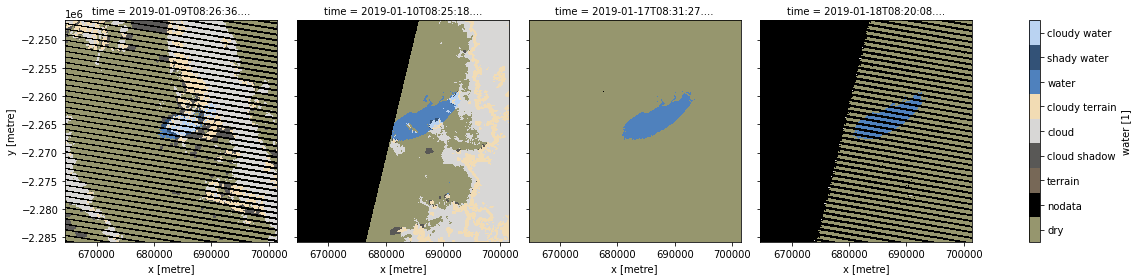

In [7]:
# Show areas that are water in the 5th timestep
plot_wofs(wofls.water, col='time', size=4, col_wrap=4);

## Masking using WOfS bit flags

WOFLs uses [bit flags](http://datacube-core.readthedocs.io/en/latest/dev/api/masking.html) to flag pixels as "wet" or otherwise. For more details on bitmasking with WOfS, see the [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook.

We can convert the WOfS bit field into a binary array containing True and False values. This allows us to use the WOFL data as a mask that can be applied to other datasets.

The `make_mask` function allows us to create a mask using the flag labels (e.g. "wet" or "dry") rather than the binary numbersin the mask. For example, we can easily identify pixels that were wet in each image (i.e. yellow) by passing the flag `wet=True`:


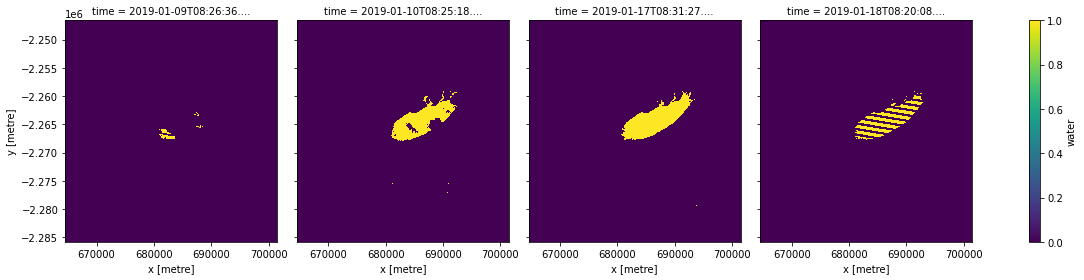

In [8]:
# Keeping only dry, non-cloudy pixels
wofls_wet = masking.make_mask(wofls, wet=True)

# Plot output mask
wofls_wet.water.plot(col='time', size=4, col_wrap=4);


## Loading WOfS annual summaries

To look at a summary of WOFLS over a calender year, we can load the  `wofs_ls_summary_annual` product. This can be useful to, at a glance, understand the annual dynamics of a waterbody.  The WOfS annual summary product has three measuremts: `count_wet`, `count_clear`, and `frequency` 

In [9]:
wofs_annual = dc.load(product='wofs_ls_summary_annual',
               like=wofls.geobox,
               time='2019')

print(wofs_annual)

<xarray.Dataset>
Dimensions:      (time: 1, x: 1231, y: 1306)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-02T11:59:59.999999
  * y            (y) float64 -2.247e+06 -2.247e+06 ... -2.286e+06 -2.286e+06
  * x            (x) float64 6.646e+05 6.646e+05 ... 7.014e+05 7.015e+05
    spatial_ref  int32 32634
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 35 34 34 34 34 34 34 ... 51 51 51 51 51 51
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 34N",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref


### Plotting WOfS frequency 

the plot below will have values that range from 0 to 1, where a value of 1 indicates the pixel was wet every time the satellite observated that location. Values that appraoch 1 indicate a permanent waterbody, while values less than 1 indicate a more empheral or seasonal waterbody.

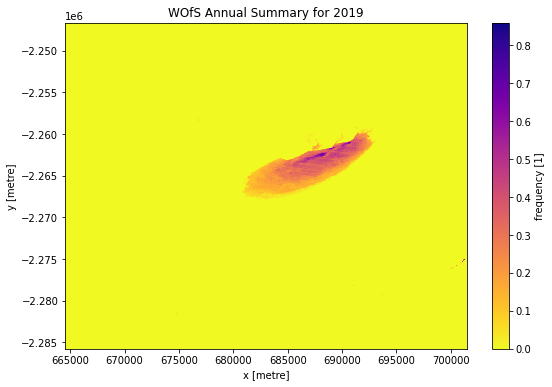

In [10]:
wofs_annual.frequency.plot(size=6, cmap='plasma_r')
plt.title('WOfS Annual Summary for 2019');

## Loading WOfS 'all-time' summaries

To look at a summary of WOFLS over the entire Landsat archive (~1984 to present), we can load the  `wofs_ls_summary_alltime` product.

In [11]:
wofs_alltime = dc.load(product='wofs_ls_summary_alltime',
               like=wofls.geobox)

print(wofs_alltime)

<xarray.Dataset>
Dimensions:      (time: 1, x: 1231, y: 1306)
Coordinates:
  * time         (time) datetime64[ns] 2002-12-31T23:59:59.999999
  * y            (y) float64 -2.247e+06 -2.247e+06 ... -2.286e+06 -2.286e+06
  * x            (x) float64 6.646e+05 6.646e+05 ... 7.014e+05 7.015e+05
    spatial_ref  int32 32634
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 473 473 473 473 474 ... 827 828 827 825 823
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 34N",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref


### Plot the WOfS all-time summary

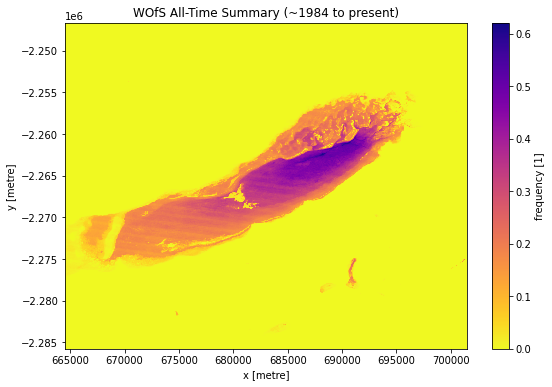

In [12]:
wofs_alltime.frequency.plot(size=6, cmap='plasma_r')
plt.title('WOfS All-Time Summary (~1984 to present)');

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [13]:
print(datacube.__version__)

1.8.5


**Last Tested:**

In [14]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-09-16'